## Ethical Analysis of Boston 311 Service: Observational Study
#### Li Sun, Yanqi Luo, Ziye Tao, Matt Roth

**Webpage: sunli-lisun.github.io/ac221/**

## **Background**

Like many cities in the U.S., Boston offers a 311 line to connect citizens with non-emergency city services. Issues such as potholes, dirty streets, broken street lights, and graffiti can be reported to the City by telephone, Twitter, web, or an app. Upon receiving a request, the City opens a case, assigns a case manager, and manages the issue through resolution. Progress and results are documented in a Constituent Relationship Management system, and made available to the public through the City’s open data portal, Analyze Boston.

Citizens are more likely to file 311 reports if 1) they have high levels of trust in city government, 2) they have time on their hands, 3) they have highly visible issues in their communities, 4) they consider 311 to be the best recourse to address their problems. These characteristics are likely to vary across individuals and communities due to historical and cultural factors. The case management and response process may be affected by historical bias. Some citizens’ or communities’ problems may be taken more seriously due to their status within society. Thus, this study combines the 311 service request datasets with demographic data, such as income, education level, poverty rate, race distribution, poverty rate, to answer the question:

**Does Boston provide 311 services fairly and equally to all citizens?**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
import plotly.express as px
from scipy import stats
import matplotlib.patches as mpatches

## **Import Data**

In [ ]:
drive.mount('/content/gdrive')
path  = '/content/gdrive/My Drive/AC221'
os.chdir(path)
os.getcwd()

Mounted at /content/gdrive


'/content/gdrive/.shortcut-targets-by-id/1pmiJfa_dSj-T0VFECrlOQhN-v5l0x5ND/AC221'

In [ ]:
# read request data
requests2018 = pd.read_csv("311_service/311_service_requests_2018.csv")
requests2019 = pd.read_csv("311_service/311_service_requests_2019.csv")
requests2020 = pd.read_csv("311_service/311_service_requests_2020.csv")
requests2021 = pd.read_csv("311_service/311_service_requests_2021.csv")
# read the demographic data
population = pd.read_csv("Demographic_new/population.csv")
education = pd.read_csv("Demographic_new/education.csv")
income = pd.read_csv("Demographic_new/income.csv")
poverty =  pd.read_csv("Demographic_new/poverty.csv")


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## **Preprocess Data**

In [ ]:
# add year column, concat 311 request datasets, cast dt columns to datetime
requests2018['year'] = '2018'
requests2019['year'] = '2019'
requests2020['year'] = '2020'
requests2021['year'] = '2021'
df_requests = pd.concat([requests2018,requests2019,requests2020,requests2021], axis=0)
df_requests[['open_dt', 'target_dt','closed_dt']] = df_requests[['open_dt', 'target_dt','closed_dt']].apply(pd.to_datetime)

# Change population numbers to int
for col in ['population','white','black','hispanic','asian','other']:
    population[col] = population[col].str.replace(',','').astype('int')

# Change education numbers to int
for col in list(education.columns)[1:]:
    education[col] = education[col].str.replace(',','').astype('int')    

# Change income numbers to int
for col in list(income.columns)[1:]:
    income[col] = income[col].str.replace('$','')
    income[col] = income[col].str.replace(',','').astype('int')

# Change poverty numbers to float
for col in list(poverty.columns)[1:]:
    poverty[col] = poverty[col].str.replace('.','')
    poverty[col] = poverty[col].str.replace('%','').astype('float')
    poverty[col] = poverty[col]/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [ ]:
df_requests.shape

(1047926, 30)

### **Merge Data Sets**

Merge request data with population, education, poverty, income and property data

In [ ]:
# merge population (race), education, income and poverty into the main dataframe
df_requests_m=df_requests.copy()
df_requests_m = df_requests.merge(population, on="neighborhood" ,how='left')
df_requests_m = df_requests_m.merge(education, on="neighborhood" ,how='left')
df_requests_m = df_requests_m.merge(poverty, on="neighborhood" ,how='left')
df_requests_m = df_requests_m.merge(income, on="neighborhood" ,how='left')

In [ ]:
# remove data with missing value in neighborhood
df_requests_m = df_requests_m[df_requests_m["neighborhood"]!=" "]
df_requests_m = df_requests_m[df_requests_m["neighborhood"].notna()]

In [ ]:
# Merge neighborhoods that are supersets of smaller neighborhoods
df_requests_m['neighborhood'] = df_requests_m['neighborhood'].replace({
    'Allston':'Allston / Brighton',
    'Brighton':'Allston / Brighton',
    'Mattapan':'Greater Mattapan',
    'South Boston':'South Boston / South Boston Waterfront',
})

In [ ]:
df_requests_m.head()

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,other,Less than high school,high school graduate,GED or alternative credential,some college,associate's degree,bachelor's degree,master's degree or more,poverty rate,per capita income
0,101002296861,2018-01-01 00:08:00,NaT,2018-03-01 15:18:12,ONTIME,Closed,Case Closed. Closed date : 2018-03-01 15:18:12...,Fire Hydrant,Boston Water & Sewer Commission,Fire Hydrant,...,1504.0,2490.0,3203.0,570.0,3789.0,886.0,9304.0,11003.0,12.8,51655.0
1,101002296862,2018-01-01 00:09:46,2018-01-02 08:30:00,2018-01-02 21:15:22,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:15:22...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,117.0,80.0,218.0,32.0,173.0,180.0,1799.0,1415.0,5.9,129651.0
2,101002296864,2018-01-01 00:11:24,2018-01-02 08:30:00,2018-01-02 21:15:11,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:15:11...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,117.0,80.0,218.0,32.0,173.0,180.0,1799.0,1415.0,5.9,129651.0
3,101002296865,2018-01-01 00:19:06,2018-01-02 08:30:00,2018-01-02 21:14:48,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:14:48...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,5050.0,15449.0,22117.0,3580.0,14716.0,4941.0,16095.0,9114.0,22.2,29767.0
4,101002296866,2018-01-01 00:21:25,2018-01-02 08:30:00,2018-01-02 21:14:32,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:14:32...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,5050.0,15449.0,22117.0,3580.0,14716.0,4941.0,16095.0,9114.0,22.2,29767.0


### **Identify Response metrics**

create response metrics : Resolved, Period, case_status

In [ ]:
# create response metrics : Resolved, Period, case_status
df_req = df_requests_m.copy()
df_req['Period'] = df_req['closed_dt'] - df_req['open_dt']
df_req['Resolved'] = 'not_resolved'
df_req.loc[df_req['closure_reason'].str.contains('Resolved'),'Resolved'] = 'resolved'

In [ ]:
# extract month variable
df_req['month'] = df_req['open_dt'].dt.month

In [ ]:
display(df_req.head())
print(df_req.columns)
print(df_req.shape)

,case_enquiry_id,open_dt,target_dt,closed_dt,ontime,case_status,closure_reason,case_title,subject,reason,...,GED or alternative credential,some college,associate's degree,bachelor's degree,master's degree or more,poverty rate,per capita income,Period,Resolved,month
0,101002296861,2018-01-01 00:08:00,NaT,2018-03-01 15:18:12,ONTIME,Closed,Case Closed. Closed date : 2018-03-01 15:18:12...,Fire Hydrant,Boston Water & Sewer Commission,Fire Hydrant,...,570.0,3789.0,886.0,9304.0,11003.0,12.8,51655.0,59 days 15:10:12,resolved,1
1,101002296862,2018-01-01 00:09:46,2018-01-02 08:30:00,2018-01-02 21:15:22,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:15:22...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,32.0,173.0,180.0,1799.0,1415.0,5.9,129651.0,1 days 21:05:36,not_resolved,1
2,101002296864,2018-01-01 00:11:24,2018-01-02 08:30:00,2018-01-02 21:15:11,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:15:11...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,32.0,173.0,180.0,1799.0,1415.0,5.9,129651.0,1 days 21:03:47,not_resolved,1
3,101002296865,2018-01-01 00:19:06,2018-01-02 08:30:00,2018-01-02 21:14:48,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:14:48...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,3580.0,14716.0,4941.0,16095.0,9114.0,22.2,29767.0,1 days 20:55:42,not_resolved,1
4,101002296866,2018-01-01 00:21:25,2018-01-02 08:30:00,2018-01-02 21:14:32,OVERDUE,Closed,Case Closed. Closed date : 2018-01-02 21:14:32...,Parking Enforcement,Transportation - Traffic Division,Enforcement & Abandoned Vehicles,...,3580.0,14716.0,4941.0,16095.0,9114.0,22.2,29767.0,1 days 20:53:07,not_resolved,1


Index(['case_enquiry_id', 'open_dt', 'target_dt', 'closed_dt', 'ontime',
       'case_status', 'closure_reason', 'case_title', 'subject', 'reason',
       'type', 'queue', 'department', 'submittedphoto', 'closedphoto',
       'location', 'fire_district', 'pwd_district', 'city_council_district',
       'police_district', 'neighborhood', 'neighborhood_services_district',
       'ward', 'precinct', 'location_street_name', 'location_zipcode',
       'latitude', 'longitude', 'source', 'year', 'population', 'white',
       'black', 'hispanic', 'asian', 'other', 'Less than high school',
       'high school graduate', 'GED or alternative credential', 'some college',
       'associate's degree', 'bachelor's degree', 'master's degree or more',
       'poverty rate', 'per capita income', 'Period', 'Resolved', 'month'],
      dtype='object')
(1033157, 48)


## **Exploratory Data Analysis**

#### **311 Report Request Number in Different Neighborhood**

In [ ]:
df_requests_count = df_requests.groupby(['latitude', 'longitude']).size().to_frame().reset_index()
df_requests_count = df_requests_count.rename(columns={0:"count"})
fig = px.density_mapbox(df_requests_count, lat='latitude', lon='longitude', z="count", radius=4,
                        center=dict(lat=42.25, lon=-71.1), zoom=10,range_color=(1,300),
                        mapbox_style="stamen-terrain")
fig.show()

The map intuitively shows that 311 report request numbers vary a lot geographically (see jupyter notebook for interactive version). The northeastern part is yellower than the southwestern part which indicates that citizens in the northeastern part generate more requests than the citizens in the southwestern part.

In [ ]:
number_neighborhood = df_req.groupby('neighborhood').size().reset_index()
number_neighborhood = number_neighborhood.rename(columns = {0:'request number'})
number_neighborhood

,neighborhood,request number
0,Allston / Brighton,81163
1,Back Bay,52353
2,Beacon Hill,28938
3,Boston,31140
4,Charlestown,36804
5,Chestnut Hill,54
6,Dorchester,151335
7,Downtown / Financial District,62385
8,East Boston,66301
9,Fenway / Kenmore / Audubon Circle / Longwood,22115


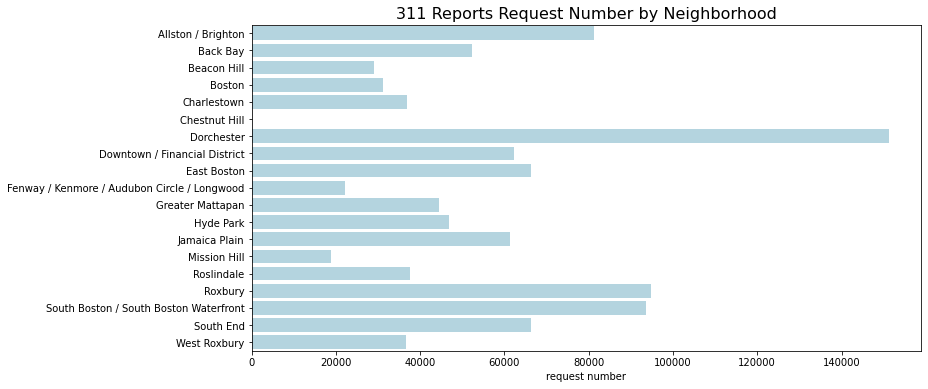

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(
    data=number_neighborhood,
    x='request number',
    y='neighborhood',
    color='lightblue'
)

plt.ylabel(None)
plt.xlabel('request number')
plt.title('311 Reports Request Number by Neighborhood', fontsize=16)
plt.show()

Dorchester is the neighborhood that has the largest number of requests followed by Roxbury and South Boston/ South Boston Waterfront. They are all located in the middle or the northern part of the previous map. In contrast, Chestnut Hill, Mission Hill, and Fenway/ Kenmore/ Audubon Circle/ Longwood are the neighborhoods with lower request numbers. Those neighborhoods are located in the western part.

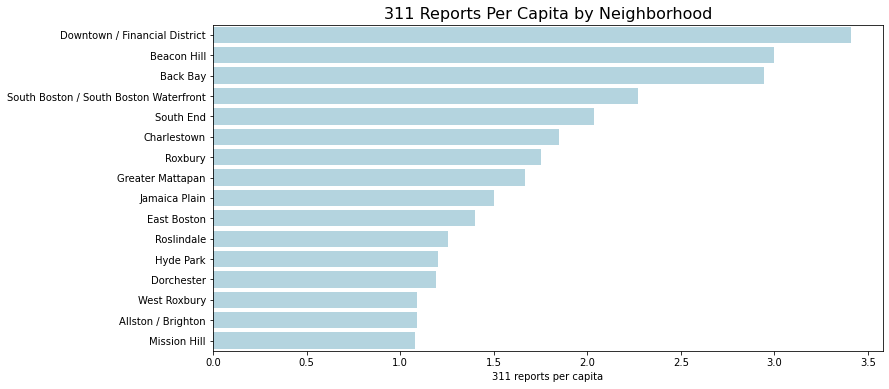

In [ ]:
# Calculate requests per capita at the neighborhood level to see which neighborhoods are over/under represented
reports_percap = np.divide(
        df_req.groupby('neighborhood')['case_enquiry_id'].nunique(),
        df_req[['neighborhood','population']].drop_duplicates().groupby('neighborhood')['population'].sum()
    ).reset_index().sort_values(by=0, ascending=False).rename(columns={0:'reports_percap'})

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(
    data=reports_percap.query('reports_percap < 100'),
    x='reports_percap',
    y='neighborhood',
    color='lightblue'
)

plt.ylabel(None)
plt.xlabel('311 reports per capita')
plt.title('311 Reports Per Capita by Neighborhood', fontsize=16)
plt.show()

We further normalize the number of 311 Reports by the population of that neighborhood. In all neighborhoods, 311 reports per capita are all greater than 1. Number of requests per capita is the highest in Downtown/ Financial District, followed by Beacon Hill and Back Bay. Misson Hill, Allston/ Brighton, and West Roxbury have relatively low request number per capita. Dorchester, which has the highest request number, does not have high report number per capita.

#### **Longitudinal Analysis**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



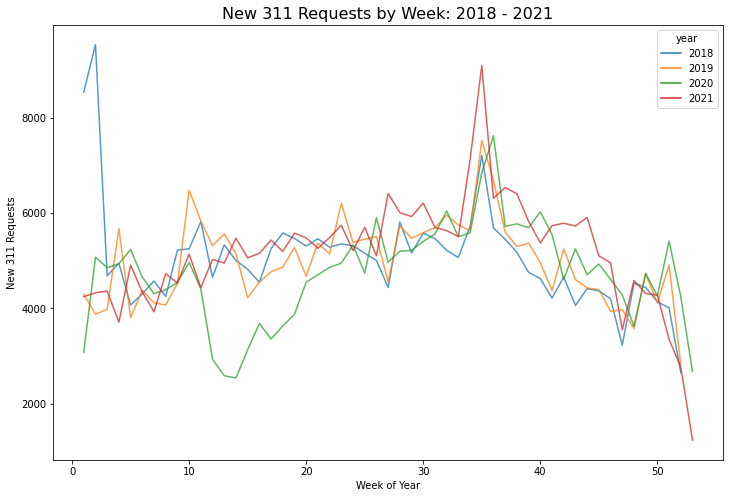

In [ ]:
# Plot seasonality and year-over-year trends
# df_requests['rownum'] = np.arange(len(df_requests))
# request_seasonality = df_requests.groupby(['year', 'open_dt'])['rownum'].nunique().reset_index()
# request_seasonality['open_dt'] = pd.to_datetime(request_seasonality['open_dt']).dt.week
df_requests['week'] = df_requests['open_dt'].dt.week
week_case = df_requests.groupby(['year','week']).size().reset_index()
week_case = week_case.rename(columns = {0:'number_per_week'})

fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(
    data=week_case,
    x='week',
    y='number_per_week',
    hue='year',
    alpha=0.75,
    # palette='viridis',
    err_style=None
)
plt.title('New 311 Requests by Week: 2018 - 2021', fontsize=16)
plt.xlabel('Week of Year')
plt.ylabel('New 311 Requests')
plt.show()

The graph below shows a seasonality trend in each year, where it increases first, peaks in summer season, then decreases. We can also notice that there is a sharp drop in request number in week 10 to week 15 of 2020. A possible explanation would be the start of Covid-19 which leads citizens to staying at home and making less requests. 

#### **311 Requests by Different Channels across Neighborhood**

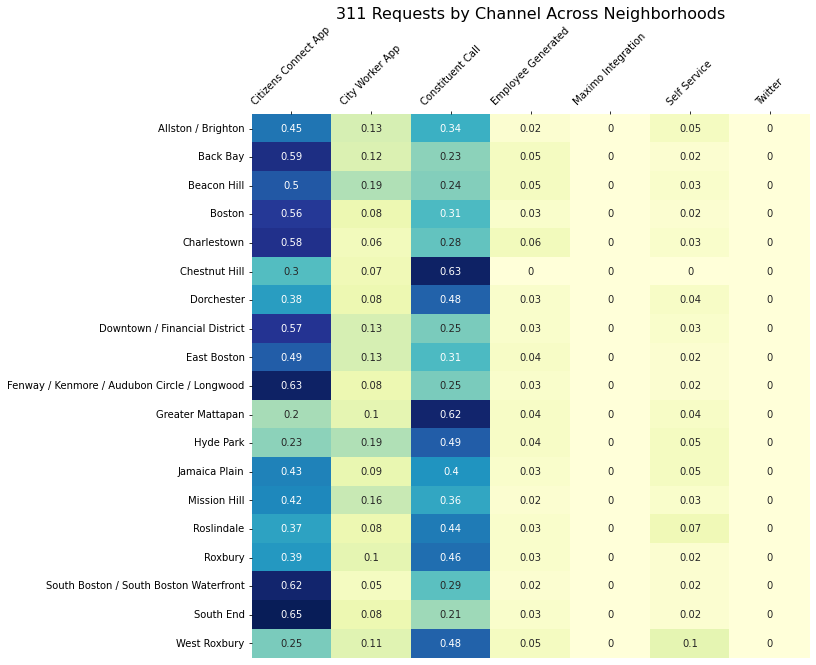

In [ ]:
# Compare source by neighborhoold (do some neighborhoods have disproportionate app access)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(
    df_req.groupby(['source','neighborhood'])['case_enquiry_id'].nunique().reset_index().pivot(
        index='neighborhood',
        columns='source',
        values='case_enquiry_id'
    ).apply(lambda x: round(x/x.sum(),2), axis=1).fillna(0).query('neighborhood != " "'),
    annot=True,
    cmap='YlGnBu',
    cbar=False
)
ax.xaxis.tick_top() 
plt.xticks(rotation=45)
plt.title('311 Requests by Channel Across Neighborhoods', fontsize=16)
plt.ylabel(None)
plt.xlabel(None)
plt.show()

There are six channels that citizens could use to report their requests. After grouping the requests by neighborhoods, heatmap is used to show the distribution of number of requests from different channels. The graph shows that there are slightly difference in the distribution of channels of different neighborhoods. 
Though the most commonly used channels are Citizens Connect APP and 311 phone calls, most neighborhoods (e.g. Back Bay, South Boston/ South Boston Waterfront) use APP more often, but there are still several neighborhoods (e.g. Chestnut Hill, Greater Mattapan) that use phone call more often. 

#### **Exploration on Resolved Rate, Close Rate, Awaiting Time**

In [ ]:
# data frame for computing average period
df_period = df_req[["neighborhood", "police_district", "case_title", "subject", "Period", "year"]]
df_period["Period"] = df_period["Period"].dt.total_seconds()
print(f"the number of neighborhood: {len(df_req['neighborhood'].unique())}")

the number of neighborhood: 19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



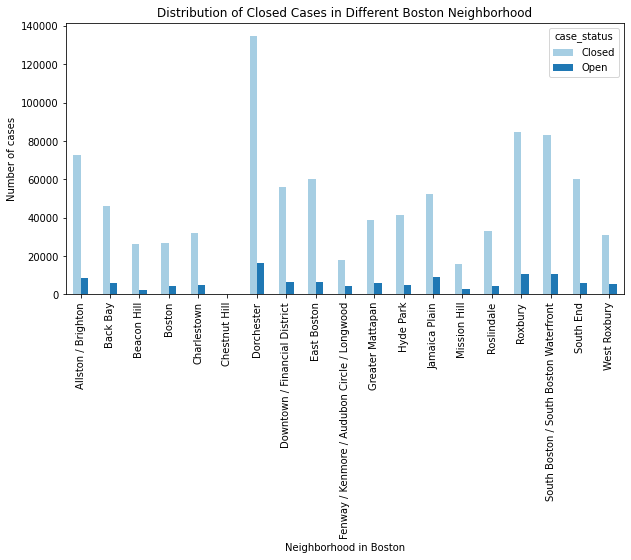

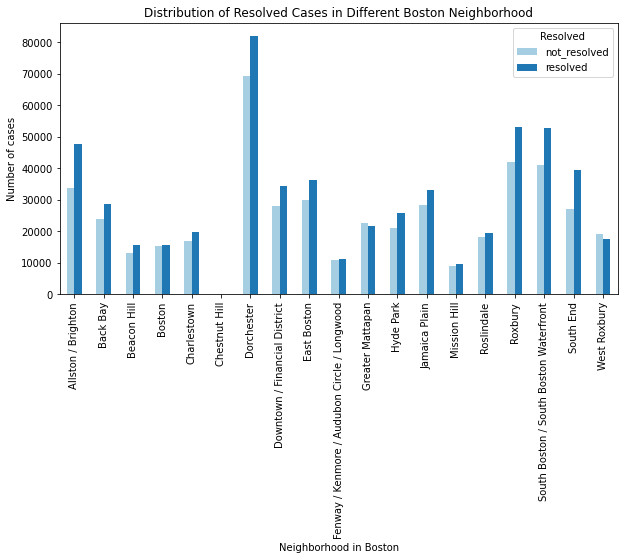

In [ ]:
# group by neighborhood, police_district to see resolve rate, closure rate, period length
neighborhood_close = df_req.groupby(["neighborhood", "case_status"]).size()
neighborhood_close.unstack(fill_value=0).plot.bar( color=sns.set_palette('Paired'), figsize=(10,5))
plt.xlabel("Neighborhood in Boston")
plt.ylabel("Number of cases")
plt.title("Distribution of Closed Cases in Different Boston Neighborhood")
plt.show()

neighborhood_resolve = df_req.groupby(["neighborhood", "Resolved"]).size()
neighborhood_resolve.unstack(fill_value=0).plot.bar(color=sns.set_palette('Paired'), figsize=(10,5))
plt.xlabel("Neighborhood in Boston")
plt.ylabel("Number of cases")
plt.title("Distribution of Resolved Cases in Different Boston Neighborhood")
plt.show()


In [ ]:
# Compute resolve rate, close rate in each neighborhood 

# resolve rate by neighbourhood
neighborhood_resolve_rate = neighborhood_resolve.groupby(level=[0]).apply(lambda g: g / g.sum()).to_frame().reset_index().rename(columns={0:"Resolved rate"})
neighborhood_resolve_rate = neighborhood_resolve_rate[neighborhood_resolve_rate["Resolved"] == "resolved"]
neighborhood_resolve_rate = neighborhood_resolve_rate.drop(columns=["Resolved"])

# close rate by neighbourhood
neighborhood_close_rate = neighborhood_close.groupby(level=[0]).apply(lambda g: g / g.sum()).to_frame().reset_index().rename(columns={0:"Closed rate"})
neighborhood_close_rate = neighborhood_close_rate[neighborhood_close_rate["case_status"] == "Closed"]
neighborhood_close_rate = neighborhood_close_rate.drop(columns=["case_status"])

# merger two
neighborhood_resolve_close_rate = neighborhood_close_rate.merge(neighborhood_resolve_rate, on=["neighborhood"], how="left")
neighborhood_resolve_close_rate["Resolved/Closed"] = neighborhood_resolve_close_rate["Resolved rate"] / neighborhood_resolve_close_rate["Closed rate"]
display(neighborhood_resolve_close_rate)

,neighborhood,Closed rate,Resolved rate,Resolved/Closed
0,Allston / Brighton,0.892796,0.585747,0.656082
1,Back Bay,0.885145,0.545203,0.615947
2,Beacon Hill,0.915544,0.546444,0.596852
3,Boston,0.860629,0.506712,0.588769
4,Charlestown,0.868248,0.539208,0.621030
5,Chestnut Hill,0.851852,0.370370,0.434783
6,Dorchester,0.891631,0.542393,0.608315
7,Downtown / Financial District,0.894686,0.551847,0.616806
8,East Boston,0.903712,0.548589,0.607040
9,Fenway / Kenmore / Audubon Circle / Longwood,0.812118,0.510061,0.628062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



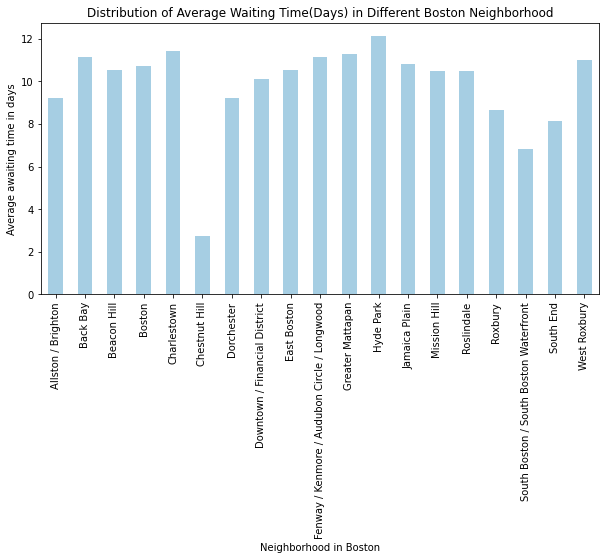

In [ ]:
# data frame for computing average period
df_period = df_req[["neighborhood", "police_district", "Period"]]
df_period["Period"] = df_period["Period"].dt.total_seconds()

neighborhood_period = df_period.groupby("neighborhood", dropna=True)["Period"].mean()/(24*3600) # average period in days
neighborhood_period.plot.bar( figsize=(10,5))
plt.xlabel("Neighborhood in Boston")
plt.ylabel("Average awaiting time in days")
plt.title("Distribution of Average Waiting Time(Days) in Different Boston Neighborhood")
plt.show()



**Closed Rate**: Most neighborhoods have close rate higher than 85%. Fenway/ Kenmore/ Audubon Circle/ Longwood is the only neighborhood has close rate (81.21%) lower than 85%. Beacon Hill has the highest closed rate (91.55%), followed by South End (91%) and East Boston (90.37%). 


**Resolved Rate**: From the graph above, Greater Mattapan and West Roxbury are the two neighborhoods with non_resolved case numbers higher than resolved case numbers which indicates the resolved rate is lower than 50%. Among the other neighborhoods, South End (59.44%) and Alluston/ Bringhton (58.57%) have relatively high resolved rate; whereas, Fenway / Kenmore / Audubon Circle / Longwood (51.01%), Mission Hill (51.46%) and Boston (50.67%) have relatively low resolved rate.

**Average Waiting Time**: On average, people need to wait at least a week for a case to be closed except in Chestnut Hill. This might due to the extreme low number of cases which bias could be introduced. South Boston/ South Boston Waterfront, South End, and Roxbury have relatively short waiting time compared to Hyde Park, Charlestown, and West Roxbury where people need to wait longer.

#### **Demographic Distribution Exploration**

Distribution of Population in Different Neighborhoods

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Distribution of Population In Different Neighborhoods')

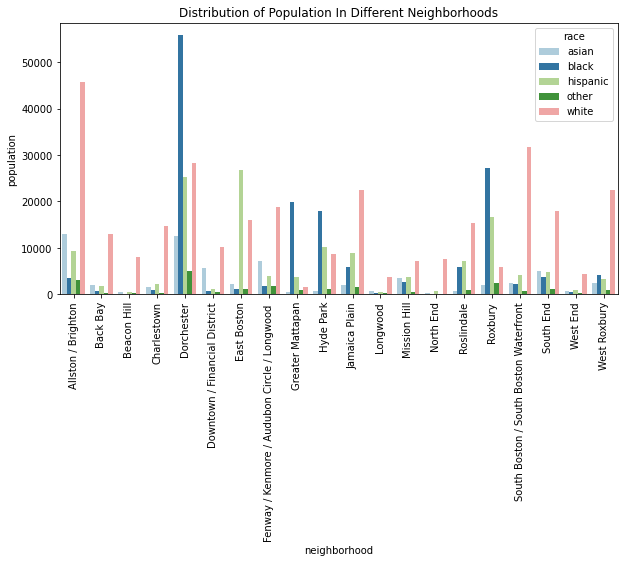

In [ ]:
popu=  population.copy()


del popu['population']


popu['neighborhood'] = popu['neighborhood'].replace({
    'Allston':'Allston / Brighton',
    'Mattapan':'Greater Mattapan',
    'South Boston':'South Boston / South Boston Waterfront',
})


plt.figure(figsize = (10,5))
popu = pd.melt(popu, id_vars=['neighborhood'], value_vars=["white", "black","hispanic","asian","other"],var_name = ['race'], value_name = 'population')
popu.head()
popu=popu.groupby(['neighborhood','race']).sum().reset_index()
sns.set_palette('Paired')
sns.barplot(popu['neighborhood'], popu['population'],hue =popu['race'] )
plt.xticks(rotation =90)
plt.title("Distribution of Population In Different Neighborhoods")

# neighborhood_resolve_close_rate.plot.bar(x="neighborhood", y="Resolved/Closed", figsize=(10,5))
# plt.xlabel("Neighborhood")
# plt.ylabel("Resolved rate / Closed rate")
# plt.title("Resolve rate over Closed rate in different neighborhood")
# plt.show()

Race distribution of each neighborhood is significantly different. Black is dominant in Dorchester, Hyde Park, Greater Mattapan, and Roxbury ; whereas White is dominant in South Boston/ South Boston Waterfront, South End, Jamaica Plain, and Allston/ Brighton. East Boston is the only neighborhood that Hispanic has the largest proportion.

Barplot of income over different neighborhoods

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Distribution of Income In Different Neighborhoods')

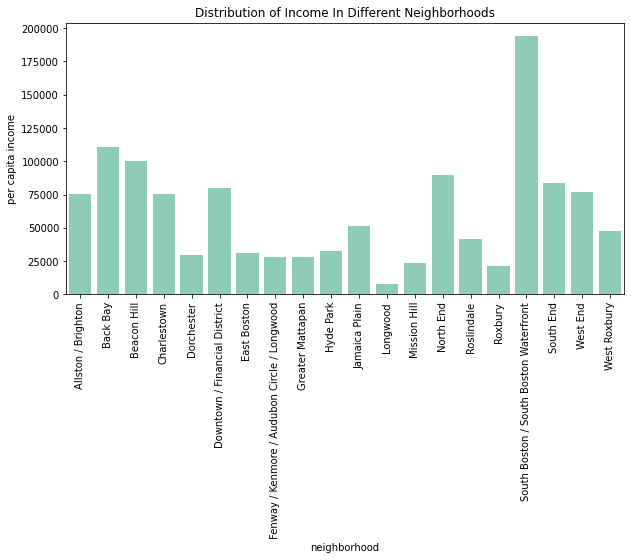

In [ ]:
income1=  income.copy()
income1['neighborhood'] = income1['neighborhood'].replace({
    'Allston':'Allston / Brighton',
    'Mattapan':'Greater Mattapan',
    'South Boston':'South Boston / South Boston Waterfront',
})

income1=income1.groupby(['neighborhood']).sum().reset_index()

plt.figure(figsize = (10,5))
sns.set_palette('Paired')
sns.barplot(income1['neighborhood'],income1['per capita income'], color = 'MediumAquamarine', alpha = 0.8)
plt.xticks(rotation  =90)
plt.title("Distribution of Income In Different Neighborhoods")

Per capita Income is significantly different in each neighborhood. The per capita income of Back Bay is the highest, and it is the only neighborhood having per capita income larger than 100,000. The per capita income of Beacon Hill and South Boston/ South Boston Waterfront are also relatively high. The per capita income of Longwood, Roxbury and Mission Hill are lower than 25,000 which are the lowest among all neighborhoods.

Barplot of Education over different neighborhoods

In [ ]:
edu =  education.copy()

edu_list =['Less than high school', 'high school graduate',
       'GED or alternative credential', 'some college', 'associate\'s degree',
       'bachelor\'s degree', 'master\'s degree or more']
edu = pd.melt(edu, id_vars=['neighborhood'], value_vars=edu_list,var_name = ['education level'], value_name = 'population')
edu['Below_Bachelor'] = 'Below_Bachelor'
edu.loc[(edu['education level'] == 'bachelor\'s degree') , 'Below_Bachelor' ] = 'Bachelor or Higher'
edu.loc[(edu['education level'] == 'master\'s degree or more') , 'Below_Bachelor' ] = 'Bachelor or Higher'
edu['neighborhood'] = edu['neighborhood'].replace({
    'Allston':'Allston / Brighton',
    'Mattapan':'Greater Mattapan',
    'South Boston':'South Boston / South Boston Waterfront',
})
edu=edu.groupby(['neighborhood','education level','Below_Bachelor']).sum().reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Distribution of Education Level In Different Neighborhoods')

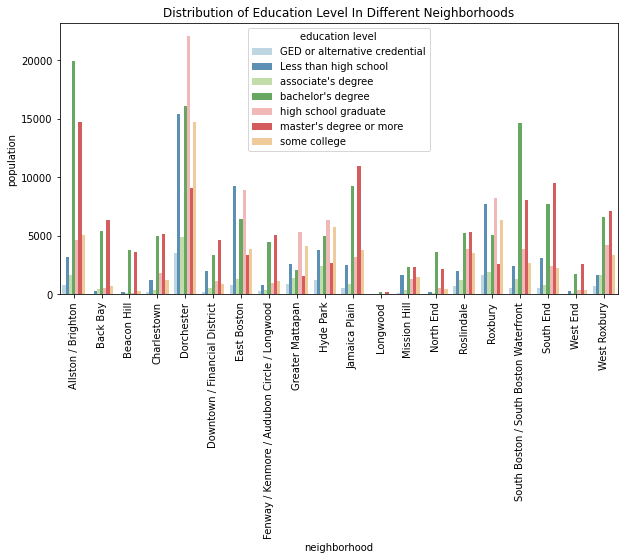

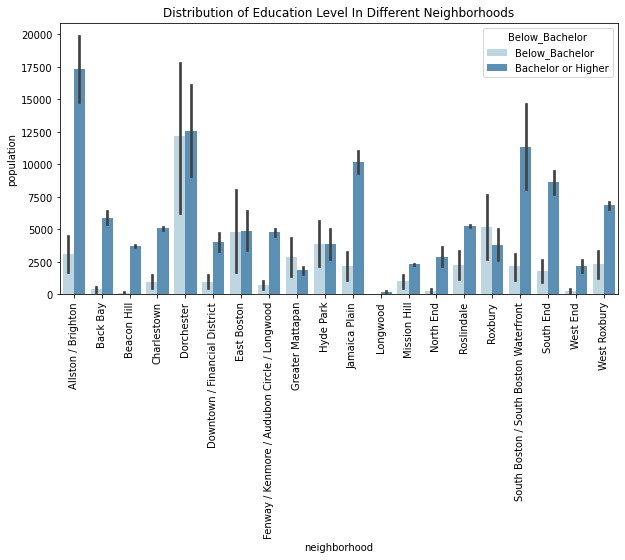

In [ ]:
plt.figure(figsize = (10,5))
sns.set_palette('Paired')
sns.barplot(edu['neighborhood'],edu['population'], hue = edu['education level'],alpha = 0.8)
plt.xticks(rotation  =90)
plt.title("Distribution of Education Level In Different Neighborhoods")

plt.figure(figsize = (10,5))
sns.set_palette('Paired')
sns.barplot(edu['neighborhood'],edu['population'], hue = edu['Below_Bachelor'],alpha = 0.8)
plt.xticks(rotation  =90)
plt.title("Distribution of Education Level In Different Neighborhoods")

Distribution of education level is different from each neighborhood. For easy visualization and comparison, education level is further categorized to two categories - "below bachelor" and "bachelor or higher". The proportion of' bachelor or higher' is higher than 'below bachelor' in the majority of neighborhoods except for Hyde Park, East Boston, Greater Mattapan, and Roxbury. Though the proportion of people with "bachelor or higher" degree is higher in Dorchester and East Boston, the proportion differences between these two groups are small. 

Barplot of Poverty over different neighborhoods

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Distribution of Poverty In Different Neighborhoods')

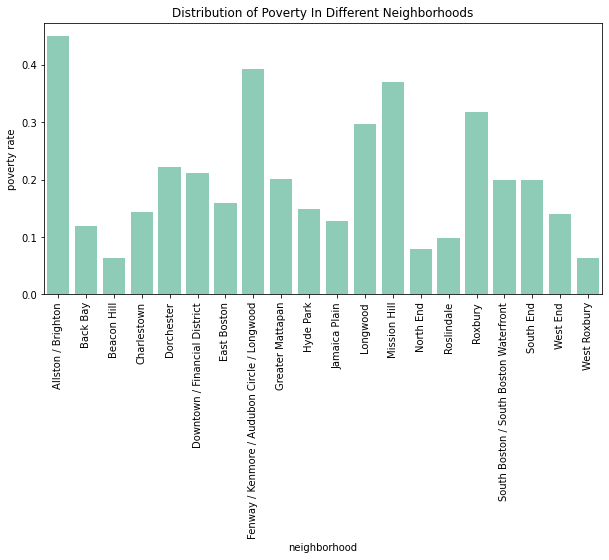

In [ ]:
poverty1=  poverty.copy()
# poverty1['poverty rate'] = poverty1['poverty rate'].str.slice(0,-1)
# poverty1['poverty rate'] = poverty1['poverty rate'].astype('float')
poverty1['neighborhood'] = poverty1['neighborhood'].replace({
    'Allston':'Allston / Brighton',
    'Mattapan':'Greater Mattapan',
    'South Boston':'South Boston / South Boston Waterfront',
})
poverty1=poverty1.groupby(['neighborhood']).sum().reset_index()

plt.figure(figsize = (10,5))
sns.set_palette('Paired')
sns.barplot(poverty1['neighborhood'],poverty1['poverty rate']/100, color = 'MediumAquamarine', alpha = 0.8)
plt.xticks(rotation  =90)
plt.title("Distribution of Poverty In Different Neighborhoods")

Distribution of poverty rate is different in each neighborhood. Ferway/ Kenmore/ Audubon Circle/ Longwood is the neighborhood with the highest poverty rate (39.2%), followed by Mission Hill, Roxbury and Longwood. All of these neighborhood have porverty rate larger than 25%. On the other side, West Roxbury has the lowest poverty rate (6.3%), followed by North End and Beacon Hill. The poverty rate of these neighborhoods are all lower than 8%.

## **Fairness Analysis**

### **Fairness Analysis based on Neighborhood**

#### **311 Interaction Level Across Different Neighborhoods**

In [ ]:
# df_req.head()
df_req['percent_white'] = df_req['white'] / df_req['population']
df_req['percent_nonwhite'] = 1 - df_req['percent_white']
df_req['percent_black'] = df_req['black'] / df_req['population']
df_req['percent_nonblack'] = 1 - df_req['percent_black']
df_req['percent_no_college'] = (df_req['Less than high school'] + df_req['high school graduate'] + df_req['GED or alternative credential']) / df_req['population']
df_req['percent_college_or_more'] = (df_req['some college'] + df_req["associate's degree"] + df_req["bachelor's degree"] + df_req["master's degree or more"])/ df_req['population']

In [ ]:
# Function to regress y on x and plot
def ols_calc_plot(data, grouping, x, y, title, xlab, ylab, ax, color='tab:blue'):
    ols_df = pd.merge(
            data,
            df_req.groupby(grouping)[x].mean().reset_index(),
            on=grouping
        )[[x, y]].replace([np.inf, -np.inf], np.nan,).dropna()

    # Regress reports_percap on income
    slope, intercept, r_value, p_value, std_err = stats.linregress(ols_df[x],ols_df[y])

    g = sns.regplot(
        data = ols_df,
        x=x,
        y=y,
        color=color,
        fit_reg=True,
        ax=ax
    ) 
    
    # Legend
    ols_eq = "y = " + str(round(intercept, 3)) + " + " + str(round(slope, 6)) + "x\np = " + str(round(p_value, 6))
    handles, labels = ax.get_legend_handles_labels()
    patch = mpatches.Patch(color=color, label=ols_eq)
    handles.append(patch) 
    ax.legend(handles=handles, loc='best')

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(xlab)


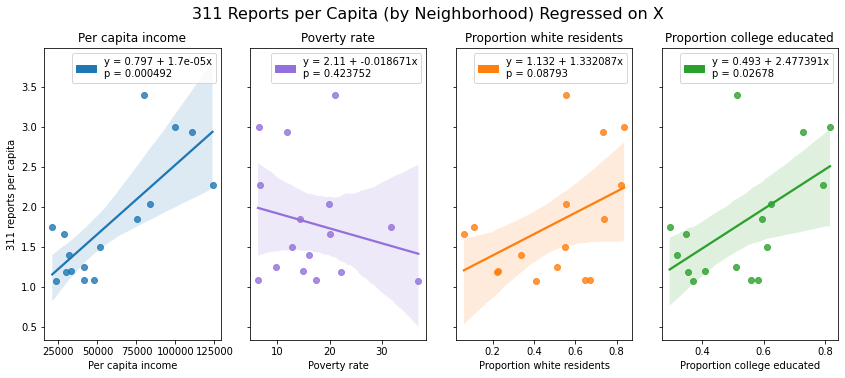

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(12,5),sharey=True)
ols_calc_plot(
    data=reports_percap,
    grouping='neighborhood',
    x='per capita income',
    y='reports_percap',
    xlab='Per capita income',
    ylab='311 reports per capita',
    title='311 Reports per capita regressed on neighborhood income',
    ax=axs[0]
)
ols_calc_plot(
    data=reports_percap,
    grouping='neighborhood',
    x='poverty rate',
    y='reports_percap',
    xlab='Poverty rate',
    ylab='311 reports per capita',
    title='311 Reports per capita regressed on poverty rate',
    color='mediumpurple',
    ax=axs[1]
)
ols_calc_plot(
    data=reports_percap,
    grouping='neighborhood',
    x='percent_white',
    y='reports_percap',
    xlab='Proportion white residents',
    ylab='311 reports per capita',
    title='311 Reports per capita regressed on percent white residents',
    color='tab:orange',
    ax=axs[2]
)
ols_calc_plot(
    data=reports_percap,
    grouping='neighborhood',
    x='percent_college_or_more',
    y='reports_percap',
    xlab='Proportion college educated',
    ylab='311 reports per capita',
    title='311 Reports per capita regressed on college education rate',
    color='tab:green',
    ax=axs[3]
)
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
axs[3].set_ylabel(None)
plt.tight_layout()
plt.suptitle('311 Reports per Capita (by Neighborhood) Regressed on X', y=1.04, fontsize=16)
plt.show()

**Summary:** A regression analysis shows that the variance in 311 reports per capita is associated with demographic characteristics such as income, race, and education (p < 0.01, 0.1, 0.05 respectively).  

**Significance:** Given that 311 services need to be requested to be provided, we can assume that neighborhoods with more 311 requests per capita will receive disproportionate benefits from city services compared with those that file fewer requests per capita (assuming all requests are attended to equally and the feasibility of resolving requests doesn't vary across neighborhoods). 

Importantly, these results demonstrate an inversion of the socially desirable allocation of resources, whereby needy neighborhoods would be the ones receiving the most support from city services. In our case, it seems like a reasonable assumption that less well-off neighborhoods are the ones that are most in need of the services offered through 311 (e.g. repairs, cleaning, beautification, maintenance etc.), but it is well-off neighborhoods that are receiving disproportionate benefits from 311 based on their higher propensity to seek services. 

**Interpretation:** There are many possible explanations for this finding. People in less well-off neighborhoods may file fewer 311 requests per capita due to a lack of awareness of 311 services, mistrust of government, less leisure time to file cases, language barriers, or preference for local community-oriented problem solving rather than reliance on city government.   

#### **Close rate, resolved rate, awaiting time Across Different Neighborhoods**

**(1) Race**


In [ ]:
awaiting_time = pd.DataFrame(neighborhood_period).reset_index()
awaiting_time.head()

,neighborhood,Period
0,Allston / Brighton,9.233614
1,Back Bay,11.155221
2,Beacon Hill,10.549661
3,Boston,10.720180
4,Charlestown,11.421841


- Correlation between White Population Proportion and Close, Resolved Rate and Awaiting Time.

In [ ]:
# Correlation between white proprotion VS close rate, resolved rate and awaiting time
df_mean = pd.DataFrame(df_req.groupby(['neighborhood'])['percent_white'].mean().reset_index())
missing_neighborhood = df_mean.loc[df_mean['percent_white'].isna(), 'neighborhood'].values.tolist()
white_prop_mean = df_req.loc[~df_req['neighborhood'].isin(missing_neighborhood)].groupby(['neighborhood'])['percent_white'].mean()
close_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Closed rate']
resolved_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Resolved rate']
awaiting_mean = awaiting_time.loc[~awaiting_time['neighborhood'].isin(missing_neighborhood),'Period']
cor_white_prop = pd.DataFrame([np.corrcoef(white_prop_mean, close_rate)[0,1], np.corrcoef(white_prop_mean, resolved_rate)[0,1], np.corrcoef(white_prop_mean, awaiting_mean)[0,1]], index = ['Close rate','Resolved rate', 'Mean Awaiting'], columns= ['percent_white']).T
cor_white_prop


,Close rate,Resolved rate,Mean Awaiting
percent_white,0.050764,0.197647,-0.14547


- Regression between white proportion VS Close rate ,Resolved rate and Awaiting Time

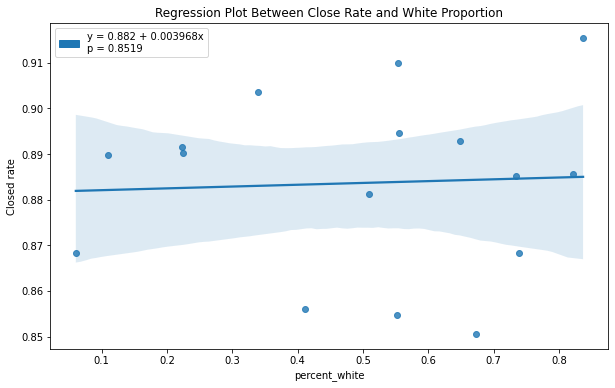

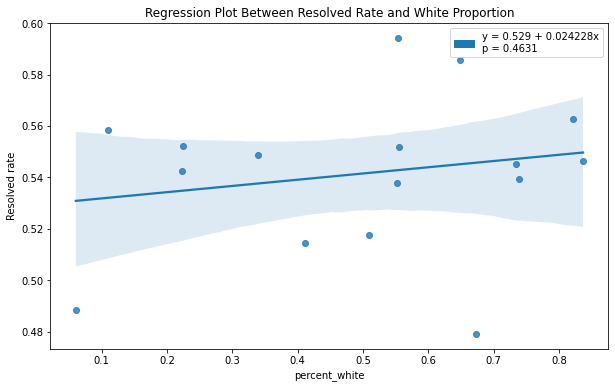

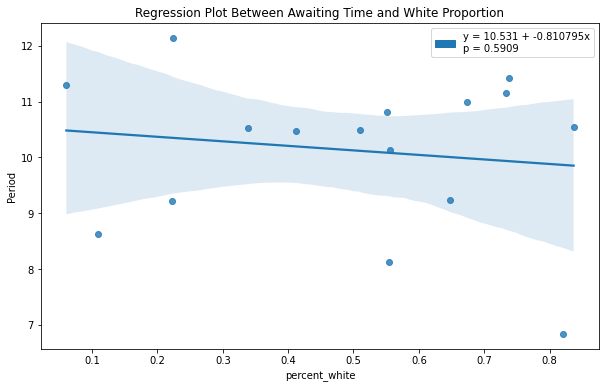

In [ ]:
# Regression between white proportion VS close rate, resolved rate and awaiting time

list_metrics = [close_rate, resolved_rate, awaiting_mean]
name_list = ['Close Rate','Resolved Rate', 'Awaiting Time']
for i in range(3):
  fig, ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
  metric = list_metrics[i]
  slope, intercept, r_value, p_value, std_err = stats.linregress(white_prop_mean,metric)
  g = sns.regplot(x=white_prop_mean,y=metric,color='tab:blue',fit_reg=True, ax = ax)
  ols_eq = "y = " + str(round(intercept, 3)) + " + " + str(round(slope, 6)) + "x\np = " + str(round(p_value, 4))
  handles, labels = ax.get_legend_handles_labels()
  patch = mpatches.Patch(color='tab:blue', label=ols_eq)
  handles.append(patch) 
  ax.legend(handles=handles, loc='best')
  # ax.set_ylim( np.min(metric) * 0.9, np.max(metric) * 1.1)
  ax.set_title(f'Regression Plot Between {name_list[i]} and White Proportion')



- Correlation & Regression between Black Population Proportion and Close, Resolved Rate and Awaiting Time.

In [ ]:
# Correlation between Black Proportion VS close rate, resolved rate and awaiting time
df_mean = pd.DataFrame(df_req.groupby(['neighborhood'])['percent_black'].mean().reset_index())
missing_neighborhood = df_mean.loc[df_mean['percent_black'].isna(), 'neighborhood'].values.tolist()
black_prop_mean = df_req.loc[~df_req['neighborhood'].isin(missing_neighborhood)].groupby(['neighborhood'])['percent_black'].mean()
close_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Closed rate']
resolved_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Resolved rate']
awaiting_mean = awaiting_time.loc[~awaiting_time['neighborhood'].isin(missing_neighborhood),'Period']
cor_black_prop = pd.DataFrame([np.corrcoef(black_prop_mean, close_rate)[0,1], np.corrcoef(black_prop_mean, resolved_rate)[0,1], np.corrcoef(black_prop_mean, awaiting_mean)[0,1]], index = ['Close rate','Resolved rate', 'Mean Awaiting'], columns= ['percent_black']).T
cor_black_prop



,Close rate,Resolved rate,Mean Awaiting
percent_black,-0.163486,-0.335092,0.167532


- Regression between black proportion VS Close rate ,Resolved rate and Awaiting Time

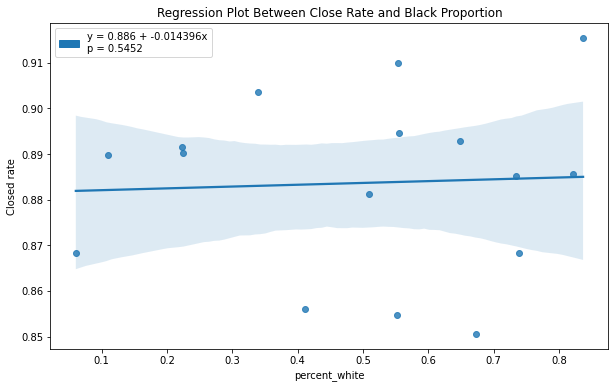

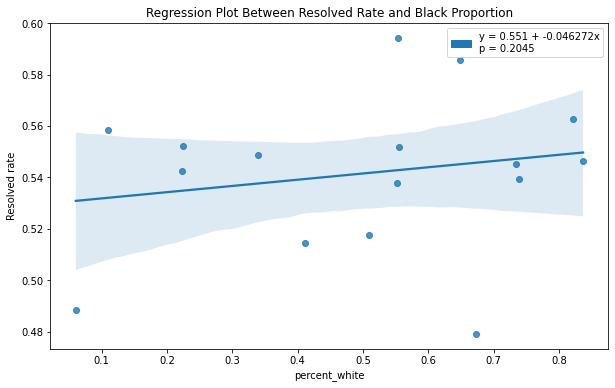

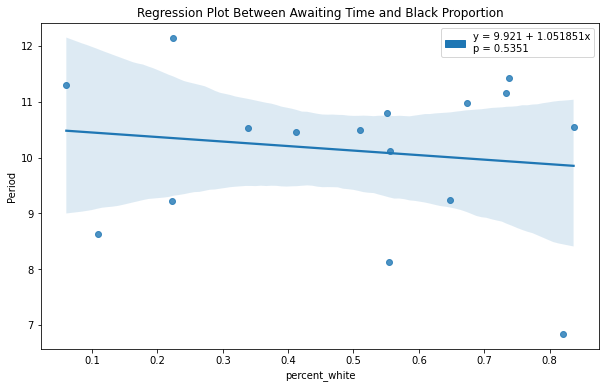

In [ ]:
# Regression between black proprotion VS close rate, resolved rate and awaiting time

list_metrics = [close_rate, resolved_rate, awaiting_mean]
name_list = ['Close Rate','Resolved Rate', 'Awaiting Time']
for i in range(3):
  fig, ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
  metric = list_metrics[i]
  slope, intercept, r_value, p_value, std_err = stats.linregress(black_prop_mean ,metric)
  g = sns.regplot(x=white_prop_mean,y=metric,color='tab:blue',fit_reg=True, ax = ax)
  ols_eq = "y = " + str(round(intercept, 3)) + " + " + str(round(slope, 6)) + "x\np = " + str(round(p_value, 4))
  handles, labels = ax.get_legend_handles_labels()
  patch = mpatches.Patch(color='tab:blue', label=ols_eq)
  handles.append(patch) 
  ax.legend(handles=handles, loc='best')
  # ax.set_ylim( np.min(metric) * 0.9, np.max(metric) * 1.1)
  ax.set_title(f'Regression Plot Between {name_list[i]} and Black Proportion')



Statistically, there is no significant relation between close rate, resolved rate and awaiting time and racial structure within neighborhood from the p-value of three corresponding regressions and correlation values. Recap from the previous section, the average awaiting time of all neighborhoods is between 7 days and 12 days (except Chestnut Hill because of the extremely small sample size). Long awaiting time can happen in any neighborhood no matter whether the majority is the White or the Black. For example, in Hyde Park, proportion of the Black is obviously higher than other races, while in West Roxbury, proportion of the White is much higher than other races. Also, short awaiting time can appear in neighborhoods with any racial structure. For example, Dorchester and Allston/Brighton are Black and White dominated respectively but the average awaiting time are both around 9 days. Therefore, there is no obvious evidence showing racial discrimination in processing 311 requests.

**2）Income**

- Correlation between income VS Close rate ,Resolved rate and Awaiting Time

In [ ]:
# correlation between income VS close rate, resolved rate and Awaiting Time
df_mean = pd.DataFrame(df_req.groupby(['neighborhood'])['per capita income'].mean().reset_index())
missing_neighborhood = df_mean.loc[df_mean['per capita income'].isna(), 'neighborhood'].values.tolist()
income_mean = df_req.loc[~df_req['neighborhood'].isin(missing_neighborhood)].groupby(['neighborhood'])['per capita income'].mean()
close_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Closed rate']
resolved_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Resolved rate']
awaiting_mean = awaiting_time.loc[~awaiting_time['neighborhood'].isin(missing_neighborhood),'Period']
cor_income = pd.DataFrame([np.corrcoef(income_mean, close_rate)[0,1], np.corrcoef(income_mean, resolved_rate)[0,1], np.corrcoef(income_mean, awaiting_mean)[0,1]], index = ['Close rate','Resolved rate', 'Mean Awaiting'], columns= ['Income']).T
cor_income



,Close rate,Resolved rate,Mean Awaiting
Income,0.359678,0.369287,-0.323304


- Regression between income VS Close rate ,Resolved rate and Awaiting Time

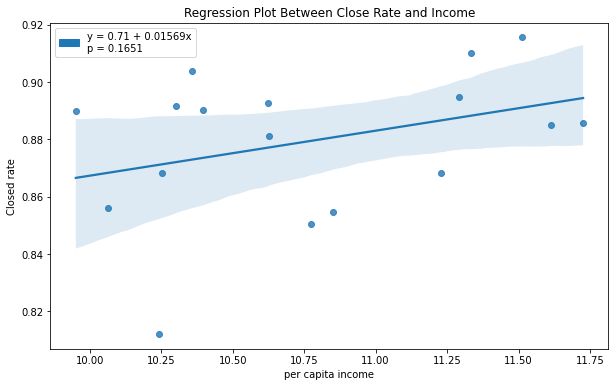

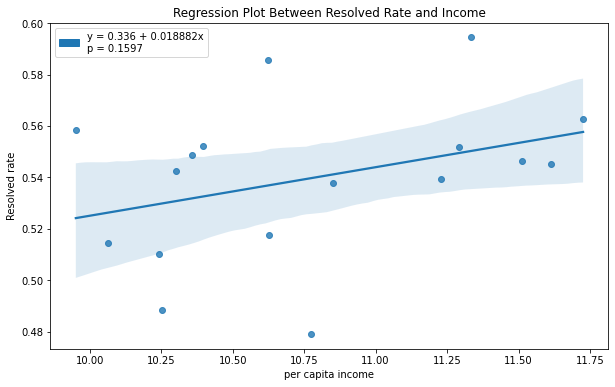

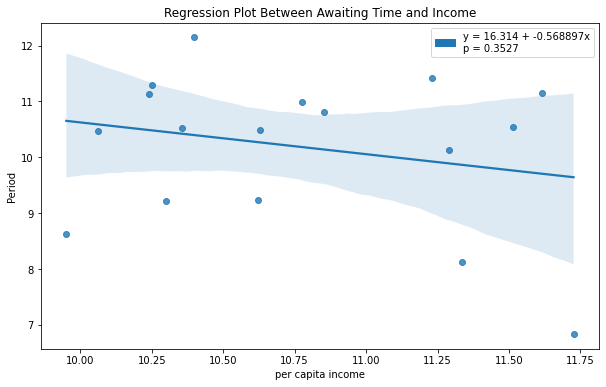

In [ ]:
# Regression between Income VS close rate, resolved rate and awaiting time

list_metrics = [close_rate, resolved_rate, awaiting_mean]
name_list = ['Close Rate','Resolved Rate', 'Awaiting Time']
for i in range(3):
  fig, ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
  metric = list_metrics[i]
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(income_mean) ,metric)
  g = sns.regplot(x=np.log(income_mean),y=metric,color='tab:blue',fit_reg=True, ax = ax)
  ols_eq = "y = " + str(round(intercept, 3)) + " + " + str(round(slope, 6)) + "x\np = " + str(round(p_value, 4))
  handles, labels = ax.get_legend_handles_labels()
  patch = mpatches.Patch(color='tab:blue', label=ols_eq)
  handles.append(patch) 
  ax.legend(handles=handles, loc='best')
  # ax.set_ylim( np.min(metric) * 0.9, np.max(metric) * 1.1)
  ax.set_title(f'Regression Plot Between {name_list[i]} and Income')



Based on the p-value from regression relation and the correlation coefficients between three response metrics (closed rate, resolved rate and awaiting time) and per capita income, there is no significant relation between income and all three response metrics. Recap that there are only three neighborhoods with close rate higher than 90%: Beacon Hill, East Boston and South End. However, the per capita income in Beacon Hill almost triples the per capita income in East Boston. Combined with the plot of awaiting time in different neighborhoods, the awaiting time in Back Bay and West Roxbury are both high but the per capita income in Back Bay almost doubles the per capita income in West Roxbury. Therefore, the relation between per capita income and fairness in processing 311 request is not obvious from the given information.

**(3) Education Level**

- Correlation between Education VS Close rate ,Resolved rate and Awaiting Time

In [ ]:
# correlation between education VS Close rate ,Resolved rate and Awaiting Time
df_mean = pd.DataFrame(df_req.groupby(['neighborhood'])['percent_college_or_more'].mean().reset_index())
missing_neighborhood = df_mean.loc[df_mean['percent_college_or_more'].isna(), 'neighborhood'].values.tolist()
college_prop_mean = df_req.loc[~df_req['neighborhood'].isin(missing_neighborhood)].groupby(['neighborhood'])['percent_college_or_more'].mean()
close_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Closed rate']
resolved_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Resolved rate']
awaiting_mean = awaiting_time.loc[~awaiting_time['neighborhood'].isin(missing_neighborhood),'Period']
cor_college_prop = pd.DataFrame([np.corrcoef(college_prop_mean, close_rate)[0,1], np.corrcoef(college_prop_mean, resolved_rate)[0,1], np.corrcoef(college_prop_mean, awaiting_mean)[0,1]], index = ['Close rate','Resolved rate', 'Mean Awaiting'], columns= ['percent_college_or_more']).T
cor_college_prop


,Close rate,Resolved rate,Mean Awaiting
percent_college_or_more,0.158577,0.264236,-0.204174


- Regression between education level VS Close rate ,Resolved rate and Awaiting Time

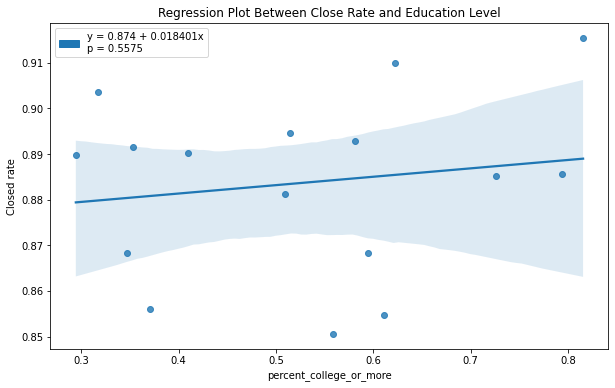

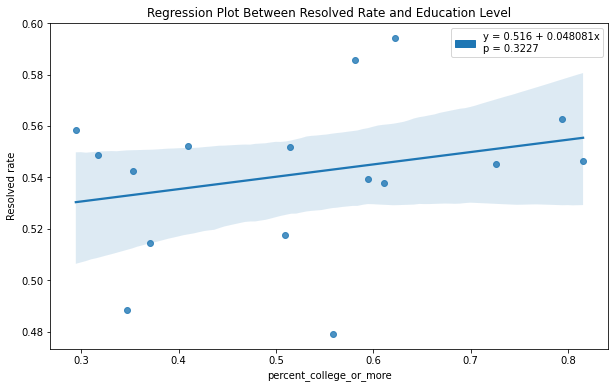

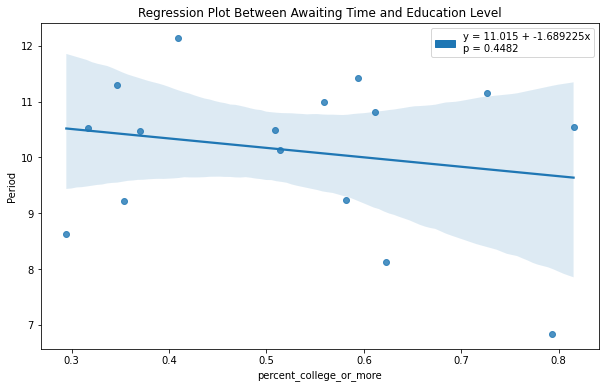

In [ ]:
# Regression between education level VS close rate, resolved rate and awaiting time

list_metrics = [close_rate, resolved_rate, awaiting_mean]
name_list = ['Close Rate','Resolved Rate', 'Awaiting Time']
for i in range(3):
  fig, ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
  metric = list_metrics[i]
  slope, intercept, r_value, p_value, std_err = stats.linregress(college_prop_mean ,metric)
  g = sns.regplot(x=college_prop_mean,y=metric,color='tab:blue',fit_reg=True, ax = ax)
  ols_eq = "y = " + str(round(intercept, 3)) + " + " + str(round(slope, 6)) + "x\np = " + str(round(p_value, 4))
  handles, labels = ax.get_legend_handles_labels()
  patch = mpatches.Patch(color='tab:blue', label=ols_eq)
  handles.append(patch) 
  ax.legend(handles=handles, loc='best')
  # ax.set_ylim( np.min(metric) * 0.9, np.max(metric) * 1.1)
  ax.set_title(f'Regression Plot Between {name_list[i]} and Education Level')

We cannot conclude that there is a significant relationship between education level and close rate/ resolved rate or awaiting time from regression results and correlation coefficients. Ferway/ Kenmore/ Audubon Circle/ Longwood is the only neighborhood with close rate lower than 85% but the population with bachelor degree or more is the absolute majority in the neighborhood. Recap that Mattapan and West Roxbury are the two neighborhoods with resolved rate lower than 50%, but proportion of bachelor or higher people in West Roxbury is much higher than that in Mattapan. For awaiting time, neighborhoods that have longer awaiting time and neighborhoods with shorter awaiting time can have similar education level structure. For example, the proportion of people with bachelor degree or more is high in both Charlestown and South Boston/ South Boston Waterfront, but the average awaiting time in Charlestown is nearly 12 days compared to the 7 days in South Boston/ South Boston Waterfront.

**(4) Poverty Rate**

- Correlation between Poverty VS Close rate ,Resolved rate and Awaiting Time

In [ ]:
df_mean = pd.DataFrame(df_req.groupby(['neighborhood'])['poverty rate'].mean().reset_index())
# df_mean.loc[df_mean['poverty rate'].isna(), 'neighborhood'].values.tolist()
# df_req[df_req['neighborhood']=='Boston']

In [ ]:
# correlation between poverty VS Close rate ,Resolved rate and Awaiting Time
df_mean = pd.DataFrame(df_req.groupby(['neighborhood'])['poverty rate'].mean().reset_index())
missing_neighborhood = df_mean.loc[df_mean['poverty rate'].isna(), 'neighborhood'].values.tolist()
poverty_mean = df_req.loc[~df_req['neighborhood'].isin(missing_neighborhood)].groupby(['neighborhood'])['poverty rate'].mean()
close_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Closed rate']
resolved_rate = neighborhood_resolve_close_rate.loc[~neighborhood_resolve_close_rate['neighborhood'].isin(missing_neighborhood)].reset_index()['Resolved rate']
awaiting_mean = awaiting_time.loc[~awaiting_time['neighborhood'].isin(missing_neighborhood),'Period']
cor_poverty = pd.DataFrame([np.corrcoef(poverty_mean, close_rate)[0,1], np.corrcoef(poverty_mean, resolved_rate)[0,1], np.corrcoef(poverty_mean, awaiting_mean)[0,1]], index = ['Close rate','Resolved rate', 'Mean Awaiting'], columns= ['Poverty']).T
cor_poverty


,Close rate,Resolved rate,Mean Awaiting
Poverty,-0.42111,-0.073302,0.000929


- Regression between Poverty rate VS Close rate ,Resolved rate and Awaiting Time

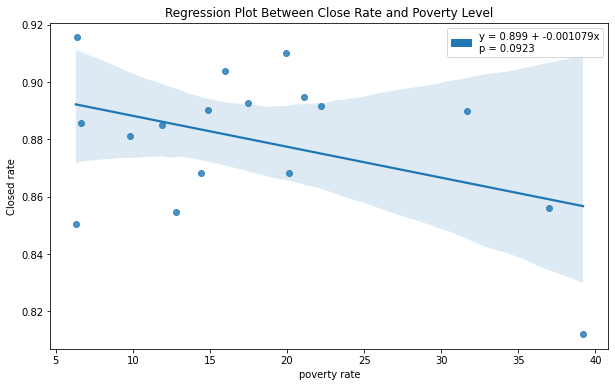

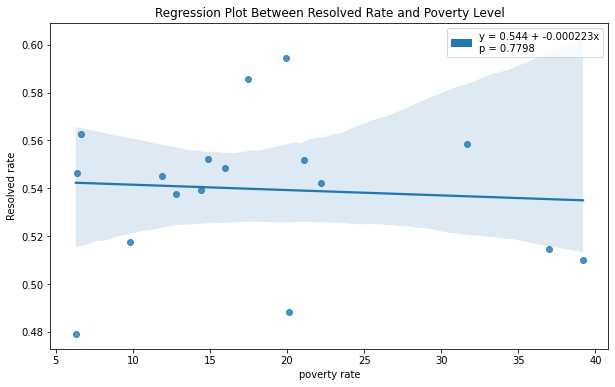

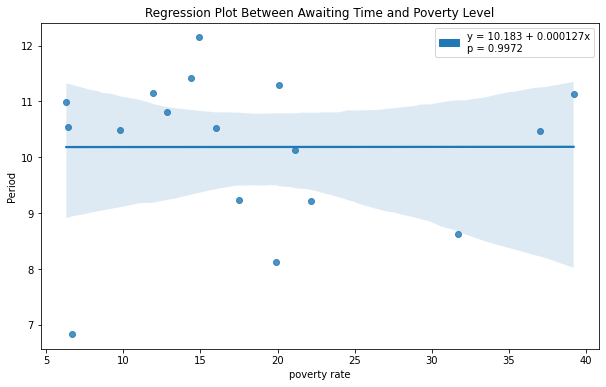

In [ ]:
 # Regression between Income VS close rate, resolved rate and awaiting time

list_metrics = [close_rate, resolved_rate, awaiting_mean]
name_list = ['Close Rate','Resolved Rate', 'Awaiting Time']
for i in range(3):
  fig, ax = plt.subplots(1,1,figsize=(10,6),sharey=True)
  metric = list_metrics[i]
  slope, intercept, r_value, p_value, std_err = stats.linregress(poverty_mean ,metric)
  g = sns.regplot(x=poverty_mean,y=metric,color='tab:blue',fit_reg=True, ax = ax)
  ols_eq = "y = " + str(round(intercept, 3)) + " + " + str(round(slope, 6)) + "x\np = " + str(round(p_value, 4))
  handles, labels = ax.get_legend_handles_labels()
  patch = mpatches.Patch(color='tab:blue', label=ols_eq)
  handles.append(patch) 
  ax.legend(handles=handles, loc='best')
  # ax.set_ylim( np.min(metric) * 0.9, np.max(metric) * 1.1)
  ax.set_title(f'Regression Plot Between {name_list[i]} and Poverty Level')



Similar with education level, there is no significant relationship between poverty rate and close rate/ resolved rate/ awaiting time from the linear regression results and correlation coefficients. Both Neighborhoods with low poverty rate and neighborhoods with high poverty rate can have high close rate. For example, the poverty in Roxbury (0.33%) is much higher than that in West Roxbury (6%), but the close rate in Roxbury (89%) is higher than that in West Roxbury (85%). As for resolved rate, there are neighborhoods with high poverty rate (such as Roxbury) that have high resolved rate, but there are also neighborhoods with low poverty rate (such as South Boston/ South Boston Waterfront) that have high resolved rate. The poverty situation in neighborhoods that have longer awaiting time is also a mix. Citizens in Fenway/ Kenmore/Audubon Circle/ Longwood (neighborhood with highest poverty rate) and West Roxbury (neighborhood with lowest poverty rate) both need to wait a long time.

**Summary**: For all four demographic factors: population, income, poverty and education level, there are no obvious relationship with response metrics. Although differences could be observed in these three metrics across neighborhoods, demographic factors are not explainable for these differences and we cannot tell any demographic discrimination in processing 311 requests. There might be other factors served as confounding variables that could cause the differences in response metrics.


### **Fairness Analysis based on Channel**

**Number of requests by channel VS.Closed rate, responsed rate, awaiting time**

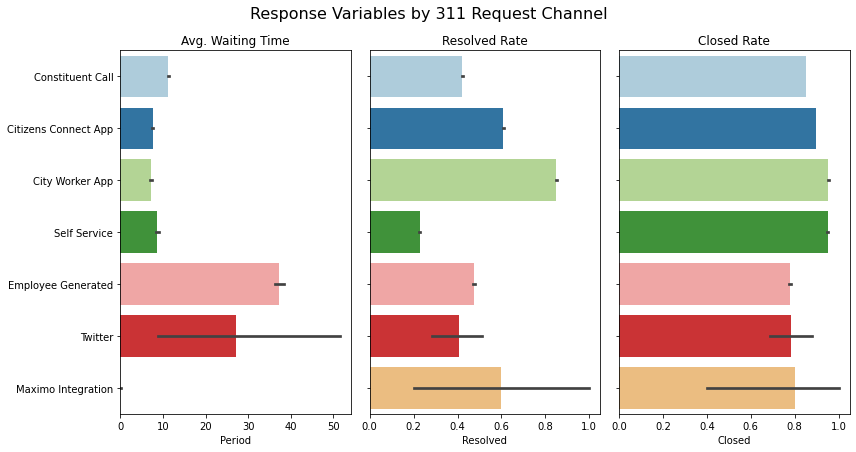

In [ ]:
# Examine response variables by request channel
channel_stats = df_req.copy()
channel_stats['Period'] = channel_stats['Period'].dt.total_seconds()/86400
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True)
sns.barplot(
    data=channel_stats,
    y='source',
    x='Period',
    ax=axs[0]
)
channel_stats['Resolved'] = channel_stats['Resolved'].replace({'not_resolved':0, 'resolved':1})
sns.barplot(
    data=channel_stats,
    y='source',
    x='Resolved',
    ax=axs[1]
)
channel_stats['Closed'] = channel_stats['case_status'].replace({'Closed':1, 'Open':0})
sns.barplot(
    data=channel_stats,
    y='source',
    x='Closed',
    ax=axs[2]
)
axs[0].set_title('Avg. Waiting Time')
axs[1].set_title('Resolved Rate')
axs[2].set_title('Closed Rate')
plt.suptitle('Response Variables by 311 Request Channel', fontsize=16, y=1.04)
axs[0].set_ylabel(None)
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
plt.tight_layout()
plt.show()

In [ ]:
# Mean waiting time by channel 
print('Mean Waiting Time by 311 Request channel')
channel_stats.groupby('source')['Period'].agg(['mean','count'])\
  .sort_values(by='count', ascending=False).reset_index()

Mean Waiting Time by 311 Request channel


,source,mean,count
0,Citizens Connect App,7.615272,426057
1,Constituent Call,11.298262,324797
2,City Worker App,7.144977,100680
3,Self Service,8.684280,36265
4,Employee Generated,37.346341,25767
5,Twitter,27.131514,58
6,Maximo Integration,0.028374,4


In [ ]:
# Resoloved rate by requestchannel 
print('Resolved Rate by 311 Request channel')
channel_stats.groupby('source')['Resolved'].agg(['mean','count'])\
  .sort_values(by='count', ascending=False).reset_index()

Resolved Rate by 311 Request channel


,source,mean,count
0,Citizens Connect App,0.608760,474747
1,Constituent Call,0.421677,381474
2,City Worker App,0.849511,105682
3,Self Service,0.227560,38135
4,Employee Generated,0.475726,33040
5,Twitter,0.405405,74
6,Maximo Integration,0.600000,5


In [ ]:
# Close rate by channel 
print('Close Rate by 311 Request channel')
channel_stats.groupby('source')['Closed'].agg(['mean','count'])\
  .sort_values(by='count', ascending=False).reset_index()

Close Rate by 311 Request channel


,source,mean,count
0,Citizens Connect App,0.897440,474747
1,Constituent Call,0.851426,381474
2,City Worker App,0.952669,105682
3,Self Service,0.950964,38135
4,Employee Generated,0.779873,33040
5,Twitter,0.783784,74
6,Maximo Integration,0.800000,5


**Summary:** From this portion of our analysis, we can see that there are statistically significant differences in our response metrics based on which channel a 311 request is filed through. The differences between "Constituent Call" and "Citizens Connect App" are the most important, as these two channels are used by citizens in 83% of all cases filed (46% app, 37% call). 

**Significance:** In terms of outcomes, the app appears to be a better channel for filing cases. Cases filed through the app have a significantly shorter waiting time than cases filed over the phone (7.6 days compared to 11.3 days), a much higher resolution rate (61% compared to 42%), and a higher close rate (90% compared to 85%). We suspect these differences are due to the amount and quality of information collected through each channel. The app collects useful data that does not come through phone requests, such as photos and geo-coordinates. The app also provides a more consistent, form-based structure for information gathering, whereas phone requests are more conversational. As a result, cases filed through the app may be easier for case workers to scope, understand, locate, and resolve.

**Implications:** These findings may have important implications on the fairness of Boston's 311 services. If app usage varies across neighborhoods, some may end up receiving better service than others (i.e. faster response time, higher resolution rate, more case closure). It would be more troubling if app usage were to correlate with neighborhood-level demographic characteristics such as race, income, and education. The next section explores these questions. 





**App usage vs demographic information**

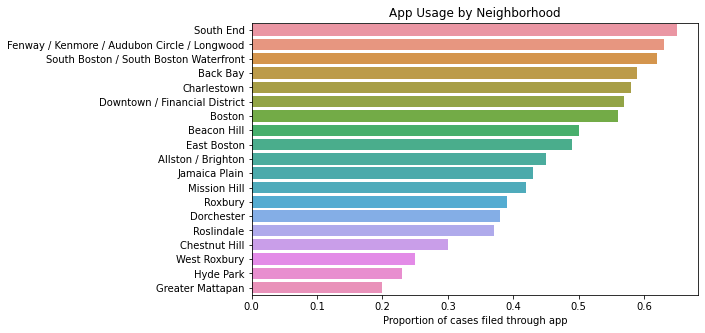

In [ ]:
# Given that app usage seems to result in shorter waiting timea and higher resolution, is it correlated with demo variables?

# Calc app usage by neighborhood
app_usage = df_req.groupby(['source','neighborhood'])['case_enquiry_id'].nunique().reset_index().pivot(
        index='neighborhood',
        columns='source',
        values='case_enquiry_id'
    ).apply(lambda x: round(x/x.sum(),2), axis=1).fillna(0).query('neighborhood != " "').reset_index()[['neighborhood','Citizens Connect App']]

# Plot app usage by neighborhood
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(
    data=app_usage.sort_values(by='Citizens Connect App', ascending=False),
    y='neighborhood',
    x='Citizens Connect App'
)
plt.title('App Usage by Neighborhood')
plt.xlabel('Proportion of cases filed through app')
plt.ylabel(None)
plt.show()


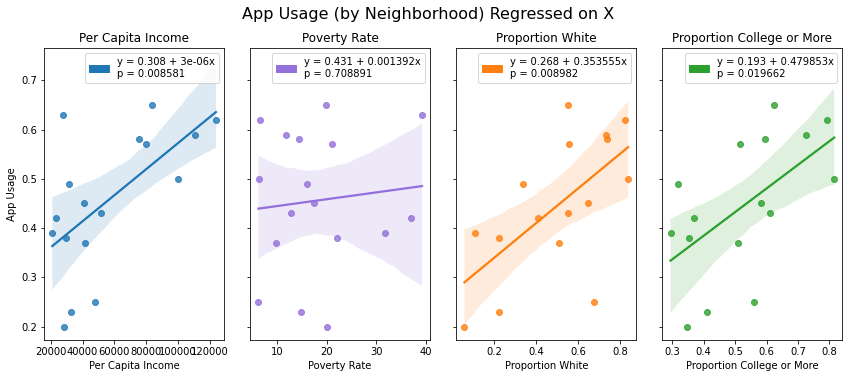

In [ ]:
# Plot regressions of app usage on demo variables
fig, axs = plt.subplots(1,4,figsize=(12,5),sharey=True)
ols_calc_plot(
    data=app_usage,
    grouping='neighborhood',
    x='per capita income',
    y='Citizens Connect App',
    xlab='Per Capita Income',
    ylab='App Usage',
    title=' ',
    ax=axs[0]
)
ols_calc_plot(
    data=app_usage,
    grouping='neighborhood',
    x='poverty rate',
    y='Citizens Connect App',
    xlab='Poverty Rate',
    ylab='App Usage',
    title=' ',
    color='mediumpurple',
    ax=axs[1]
)
ols_calc_plot(
    data=app_usage,
    grouping='neighborhood',
    x='percent_white',
    y='Citizens Connect App',
    xlab='Proportion White',
    ylab='App Usage',
    title=' ',
    color='tab:orange',
    ax=axs[2]
)
ols_calc_plot(
    data=app_usage,
    grouping='neighborhood',
    x='percent_college_or_more',
    y='Citizens Connect App',
    xlab='Proportion College or More',
    ylab='App Usage',
    title=' ',
    color='tab:green',
    ax=axs[3]
)
plt.suptitle('App Usage (by Neighborhood) Regressed on X', y=1.04, fontsize=16)
axs[1].set_ylabel(None)
axs[2].set_ylabel(None)
axs[3].set_ylabel(None)
plt.tight_layout()
plt.show()

**Neighborhood-level app usage:** First, we find that there is a large amount of variance in app usage by neighborhood. Some, such as South End, have more than 60% of their cases filed through the app, while others, such as Greater Mattapan, have roughly 20%. Based on our previous analysis, we would expect those neighborhoods with higher app usage to receive better services.

**Demographic Differences:** More concerning is the association that app usage has with demographic characteristics. Neighborhoods that are richer, whiter, and more educated have significantly higher rates of app usage (p < 0.01 for per capita income and education, p < 0.05 for whiteness), suggesting that well off neighborhoods are more likely to receive fast and effective service by virtue of their higher propensity to use the app. 

**Possible Explanations:** The differences in app usage and its correlation with neighborhood-level demographic characteristics may be due to several factors. First, citizens in well-off neighborhoods may be more likely to have smartphones. Second, they may be more aware of the Citizen Connect App due to marketing or word of mouth. Third, they may belong to demographic groups that would have an easier time using the app effectively (e.g. younger, more tech-savvy, and higher english proficiency). The 311 phone service may be comparatively attractive to citizens who don't have access to the app or prefer the phone line due to technological or language constraints. 

**Recommendations:** The city should aim to equalize its service provision across neighborhoods by expanding app usage into less well-off neighborhoods and improving case outcomes from phone requests. This effort should involve 1) studying why discrepancies in channel usage exist, 2) making an effort to raise awareness and adoption of the Citizen Connect App, 3) ensuring equal accessibility on both the app and phone line (e.g. any language offered on the phone line should be supported by the app), and 4) streamlining the data collection and case resolution process for phone requests.



## **Conclusion**

### **High-Level Trends & Insights**

From the longitudinal analysis, there is a noticeable seasonality pattern in the request number, which increases first, peaks in summer and then decreases. A sharp drop of the request number occurred in the early stage of 2020 when the Covid-19 started. From the distribution analysis across neighborhood, the number of requests across neighborhoods vary a lot. Citizens in the northeastern part of Boston generally produce more requests than citizens in the southwestern part as shown in the heat map. When normalizing the number of 311 requests by the population, the number of 311 requests per capita are all greater than 1, and the distribution of 311 reports per capital is different from the distribution of absolute request numbers across neighborhoods. As for request channels, two most commonly used channels in most neighborhoods are ‘Citizens Connect APP’ and ‘Constituent Call’.  The distribution of close cases vary in different Boston neighborhoods, and most neighborhoods have close rate higher than 85%. The distribution of resolved cases and average awaiting time in different neighborhoods are also different. On average, it takes at least one week before the case is closed. From the demographic analysis, the distributions of race, income, education and poverty level in each neighborhood are significantly different. 


### **Fairness & Bias**

While we find it unlikely that there is any explicit bias in Boston's 311 service provision (e.g. intentional prioritization of well-off neighborhoods or witholding of services from needy ones), we find discrepancies along demographic lines in the way the service is used, making it likely that neighborhoods do not receive equal treatment from city government through 311. 

Neighborhoods that are whiter and more well-off tend to file more 311 reports per capita, suggesting that their residents receive disproportionate attention, resources, and benefits from the city through 311 service provision. Less well-off neighborhoods presumably have a greater need for 311 services, so this imbalance should be corrected by the city to mitigate inequality in living conditions between the most and least well-off areas.

Additionally, our analysis suggests that whiter and more well-off neighborhoods have a stronger preference for using the Citizen Connect App compared to their less well-off counterparts, which increases the likelihood that their cases are solved quickly and successfully. 

These factors, taken together, provide strong evidence for the existence of conditions leading to unequal outcomes along demographic lines, and a logical explanation for how it might occur. Simply put, residents of whiter and more well-off neighborhoods are more likely to benefit from 311 services due to disproportionate usage of the system through more effective channels. 

### **Limitations**

 Our ability to detect bias in the dataset is limited by the granularity of demographic data we were able to match to reported cases. The 311 dataset does not have any personal details attached to cases, so all demographic data in our analysis was aggregated to the neighborhood-level. This prevented us from making any direct assessments on representation bias and individual treatment according to demographic factors. Our neighborhood-aggregated data may have obscured important insights we could not access at the individual level. For example, individual-level detail may have revealed which demographic groups within each neighborhood were filing 311 cases. Perhaps it was only the poorest quartile in each neighborhood using 311 - in that case, our concerns about the association between neighborhood-level income and reports per capita would be unwarranted. Perhaps certain demographic groups were underrepresented in case reports - in that case the city might want to consider intentional efforts to expand usage withon those subgroups so that their needs are being addressed.  



### **Recommendations:**

 Given our findings, we believe the City of Boston can improve the efficiency and fairness of its 311 service by undertaking the following measures:
1. Allocating more resources toward 311 case resolution during the seasonal peaks
2. Researching barriers to 311 access and usage - the city must understand why usage varies so much by neighborhood, and why demographic characteristics are associated with different levels and patterns of 311 usage
3. Equalizing case resolution by request channel - citizens should not be at a disadvantage based on their preferred channel for interacting with city government. The city should first analyze why outcomes are so much better when cases are filed through the app and subsequently close the gap. This might involve streamlining the information intake process over the phone, adding more languages to the app, or other operational improvements
4. Increasing awareness and adoption of 311 services among the neediest communities. This may involve targeted marketing, partnering with community based organizations, and overcoming trust barriers preventing communities from turning to the government to solve their problems




### **Open Questions and Further Analysis** 

Future research can look into whether disparate outcomes exists when controlling for the type of case that people file with 311. Some types of cases, such as pothole repair, are probably more complicated and time consuming than others, such as needle pickup. Our findings of discrepancies across neighborhoods along demographic lines may be influenced by the types of cases that get filed in different neighborhoods. For example, if low-income neighborhoods tended to file complex cases, it would not be a surprise to see longer waiting times and lower resolution rates. 

More analysis on background and historical conditions in Boston could explain differences in the willingness to use 311 and the effectiveness of the service. It could also shed light on sources of historical bias that continue to affect interactions between city government and its residents. 

